In [41]:
import time
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import sklearn 
import sklearn.preprocessing

In [42]:
# params
seed = 42

In [98]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data',
                 header = None, sep = ' ')

# based on the .doc data description
df.columns = ['cheq_acc', 'dur_t', 'cred_hist', 'purp', 'cred_amt', 'save_acc', 
              'empl_t', 'inst_to_income', 'pers_status', 'guarant_flg',
              'residence_t', 'prop', 'age', 'inst_plan', 'house', 'n_loans',
              'job', 'n_depend', 'tel_flg', 'foreign_flg', 'target']

df.head()

,cheq_acc,dur_t,cred_hist,purp,cred_amt,save_acc,empl_t,inst_to_income,pers_status,guarant_flg,...,prop,age,inst_plan,house,n_loans,job,n_depend,tel_flg,foreign_flg,target
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [99]:
X = df.loc[:, df.columns != 'target']
y = df.target - 1

In [122]:
df = pd.read_csv("credit_train.csv", sep = ',')
df = df[:-514]
del df["Loan ID"]
del df["Customer ID"]
df = df.rename(columns={'Loan Status': 'target'}) 
df['Purpose'] = df['Purpose'].replace('other', 'Other')
df['target'] = df['target'].replace('Fully Paid', 0)
df['target'] = df['target'].replace('Charged Off', 1)
df['Years in current job'] = df['Years in current job'].fillna('Unknown')

In [123]:
X = df.loc[:, df.columns != 'target']
y = df.target

In [45]:
#Подготовка
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score


def Gini(y, y_pred):
    res = roc_auc_score(y, y_pred) * 2 - 1
    return(res)

In [46]:
from modules.encoders import WoEEncoder_adj
from feature_engine.encoding import OneHotEncoder
OneHot_module = OneHotEncoder()
WoE_module = WoEEncoder_adj()

In [47]:
StScal_mdl = sklearn.preprocessing.StandardScaler()
MMScal_mdl = sklearn.preprocessing.MinMaxScaler(feature_range=(1, 2))
RobScal_mdl = sklearn.preprocessing.RobustScaler()

In [48]:
from feature_engine.outliers import Winsorizer
from feature_engine.transformation import LogTransformer
from feature_engine.transformation import PowerTransformer
from feature_engine.transformation import BoxCoxTransformer
from feature_engine.transformation import YeoJohnsonTransformer

WinsTrans_module = Winsorizer()
LogTrans_module  = LogTransformer(base = '10')
PwrTrans_module  = PowerTransformer(exp = 0.5)
BxCxTrans_module = BoxCoxTransformer()
YeoJTrans_module = YeoJohnsonTransformer()


In [49]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler

RUS_module    = RandomUnderSampler(random_state = seed)
ROS_module    = RandomOverSampler(random_state = seed)
SMOTE_module  = SMOTE(random_state = seed)
ADASYN_module = ADASYN(random_state = seed)

In [50]:
lgbm_mdl = LGBMClassifier(
    num_leaves = 12,
    learning_rate = .1,
    reg_alpha = 0,
    reg_lambda = 9,
    n_estimators= 100,
    random_state = seed
)


from feature_engine.selection  import SmartCorrelatedSelection
SmartSel_module = SmartCorrelatedSelection(
    # variables=X.columns.to_list(),
    method="pearson",                # можно взять свою функцию
    threshold=0.3,                   # порог корреляции
    selection_method="variance",     # из коррелирующих групп выбираем признак с наиб дисперсией
    estimator=None,                  # понадобится для selection_method="model_performance"        
    cv=5
)
from feature_engine.selection  import RecursiveFeatureAddition
RecFeatAdd_module = RecursiveFeatureAddition( # rather slow
    lgbm_mdl,
    threshold = 0.005
)

In [51]:
# import umap
import umap.umap_ as umap

class DimensionReducer():
    """
    Ugly wrapper fir various dimension reduction classes. Needed for 2 reasons:
    1. Features are not replaced, new ones are just added to df
    2. PCA output: np.array, should be replaced with pd.DataFrame 
    
    Comment AM: 
    1. Could be united with TransformerAdj class below, 
    2. .super() could be used
    """
    def __init__(self, gen_class, affx='feat', **kwargs):
        self.reducer = gen_class(**kwargs)
        self.affx = affx
        # self.reducer.set_params()
        
    def fit(self, X, y):
        self.reducer.fit(X, y)
        return self
    
    def transform(self, X):
        # potentially 
        Z = self.reducer.transform(X)
        return Z
    
    def set_params(self, **kwargs):
        self.reducer.set_params(**kwargs)
        return self  


Isomap_module = DimensionReducer(
    gen_class = sklearn.manifold.Isomap,
    n_neighbors = 5, #количество соседей при вычислении KNN. Основной гиперпараметр, кстати (!!!)
    n_components = 15,  #сколько оставить компонент; по дефолту - 2
    path_method = "auto", #алгоритм, который вычисляет кратчайший путь. Варианты см. на странице функции. Этот подбирает сам.
    neighbors_algorithm = "auto", #алгоритм, который ищет соседей. Инстанс класса NearestNeighbours
    n_jobs = -1 #объект умеет быть многопоточным! -1 займет все ядра
)

PCA_module = DimensionReducer(
    gen_class = sklearn.decomposition.PCA,
    n_components = 2,    # сколько оставить компонентов; по дефолту - все
    whiten = False,      # отключаем whitening - декорреляцию фичей
    svd_solver = "full", # детали SVD преобразования, за подробностями см. доки
)

UMAP_module = DimensionReducer(
    gen_class = umap.UMAP,
    n_neighbors = 5,  # количество соседей при вычислении KNN. Основной гиперпараметр, кстати (!!!)
    n_components = 2, # сколько оставить компонентов; по дефолту - 2
    min_dist = 0.1    # минимальная дистанция, которую можно сохранять между точками в получающемся пространстве. 
    # Гиперпараметр. При увеличении начинает лучше улавливать общую структуру, но хуже - локальную
)

In [119]:
X a = (train.sample(n = 800,  replace=True, random_state = i))

SyntaxError: invalid syntax (Temp/ipykernel_6156/3121474621.py, line 1)

In [124]:
train = pd.concat([y, X], axis=1)

In [182]:
train = pd.concat([y, X], axis=1)
train = (train.sample(n = 1000,  replace=False, random_state = 55))
X2 = train.loc[:, train.columns != 'target']
y2 = train.target
X_train_b = []
y_train_b = []
X_bag = []
y_bag = []
for i in range (100):
    a = (train.sample(n = 1000,  replace=True, random_state = i))
    b = pd.concat([train, a, a]).drop_duplicates(keep=False)
    X_train_b.append(a.loc[:, a.columns != 'target'])
    y_train_b.append(a.target)
    X_bag.append(b.loc[:, b.columns != 'target'])
    y_bag.append(b.target)

In [125]:
train.dropna()

,target,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
2,0,99999999.0,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,29.0,18.0,1.0,297996.0,750090.0,0.0,0.0
6,0,217646.0,Short Term,730.0,1184194.0,< 1 year,Home Mortgage,Debt Consolidation,10855.08,19.6,10.0,13.0,1.0,122170.0,272052.0,1.0,0.0
8,0,548746.0,Short Term,678.0,2559110.0,2 years,Rent,Debt Consolidation,18660.28,22.6,33.0,4.0,0.0,437171.0,555038.0,0.0,0.0
10,0,99999999.0,Short Term,728.0,714628.0,3 years,Rent,Debt Consolidation,11851.06,16.0,76.0,16.0,0.0,203965.0,289784.0,0.0,0.0
12,0,99999999.0,Short Term,740.0,776188.0,< 1 year,Own Home,Debt Consolidation,11578.22,8.5,25.0,6.0,0.0,134083.0,220220.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99990,0,99999999.0,Short Term,742.0,1190046.0,< 1 year,Rent,Other,11969.81,20.1,16.0,9.0,0.0,37392.0,134442.0,0.0,0.0
99993,0,44484.0,Short Term,717.0,1152426.0,10+ years,Home Mortgage,small_business,6280.64,21.0,12.0,6.0,0.0,961932.0,0.0,0.0,0.0
99994,0,210584.0,Short Term,719.0,783389.0,1 year,Home Mortgage,Other,3727.61,17.4,18.0,6.0,0.0,456.0,259160.0,0.0,0.0
99996,0,99999999.0,Short Term,732.0,1289416.0,1 year,Rent,Debt Consolidation,13109.05,9.4,21.0,22.0,0.0,153045.0,509234.0,0.0,0.0


In [118]:
OneHot_module.transform(MeanImp_module.fit_transform(X_train_b[1])).columns

Index(['Current Loan Amount', 'Credit Score', 'Annual Income', 'Monthly Debt',
       'Years of Credit History', 'Months since last delinquent',
       'Number of Open Accounts', 'Number of Credit Problems',
       'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies',
       'Tax Liens', 'Term_Long Term', 'Term_Short Term',
       'Years in current job_10+ years', 'Years in current job_9 years',
       'Years in current job_6 years', 'Years in current job_Unknown',
       'Years in current job_5 years', 'Years in current job_7 years',
       'Years in current job_1 year', 'Years in current job_4 years',
       'Years in current job_3 years', 'Years in current job_2 years',
       'Years in current job_< 1 year', 'Years in current job_8 years',
       'Home Ownership_Rent', 'Home Ownership_Own Home',
       'Home Ownership_Home Mortgage', 'Home Ownership_HaveMortgage',
       'Purpose_Debt Consolidation', 'Purpose_Home Improvements',
       'Purpose_Other', 'Purpose_Buy House

In [72]:
from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.imputation import RandomSampleImputer
from modules.missings import teach_to_separate
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from modules.missings import missing_filler_mode
from feature_engine.imputation import ArbitraryNumberImputer

ZeroImp_module = ArbitraryNumberImputer(arbitrary_number=0)

MedImp_module = MeanMedianImputer(imputation_method='median')
MeanImp_module = MeanMedianImputer(imputation_method='mean')
MeanImp_module = MeanMedianImputer(imputation_method='mean')
ModeImp_module = missing_filler_mode()
RandomImp_module = RandomSampleImputer()
KNNImp_module = teach_to_separate(KNNImputer)
IterImp_module = teach_to_separate(IterativeImputer)

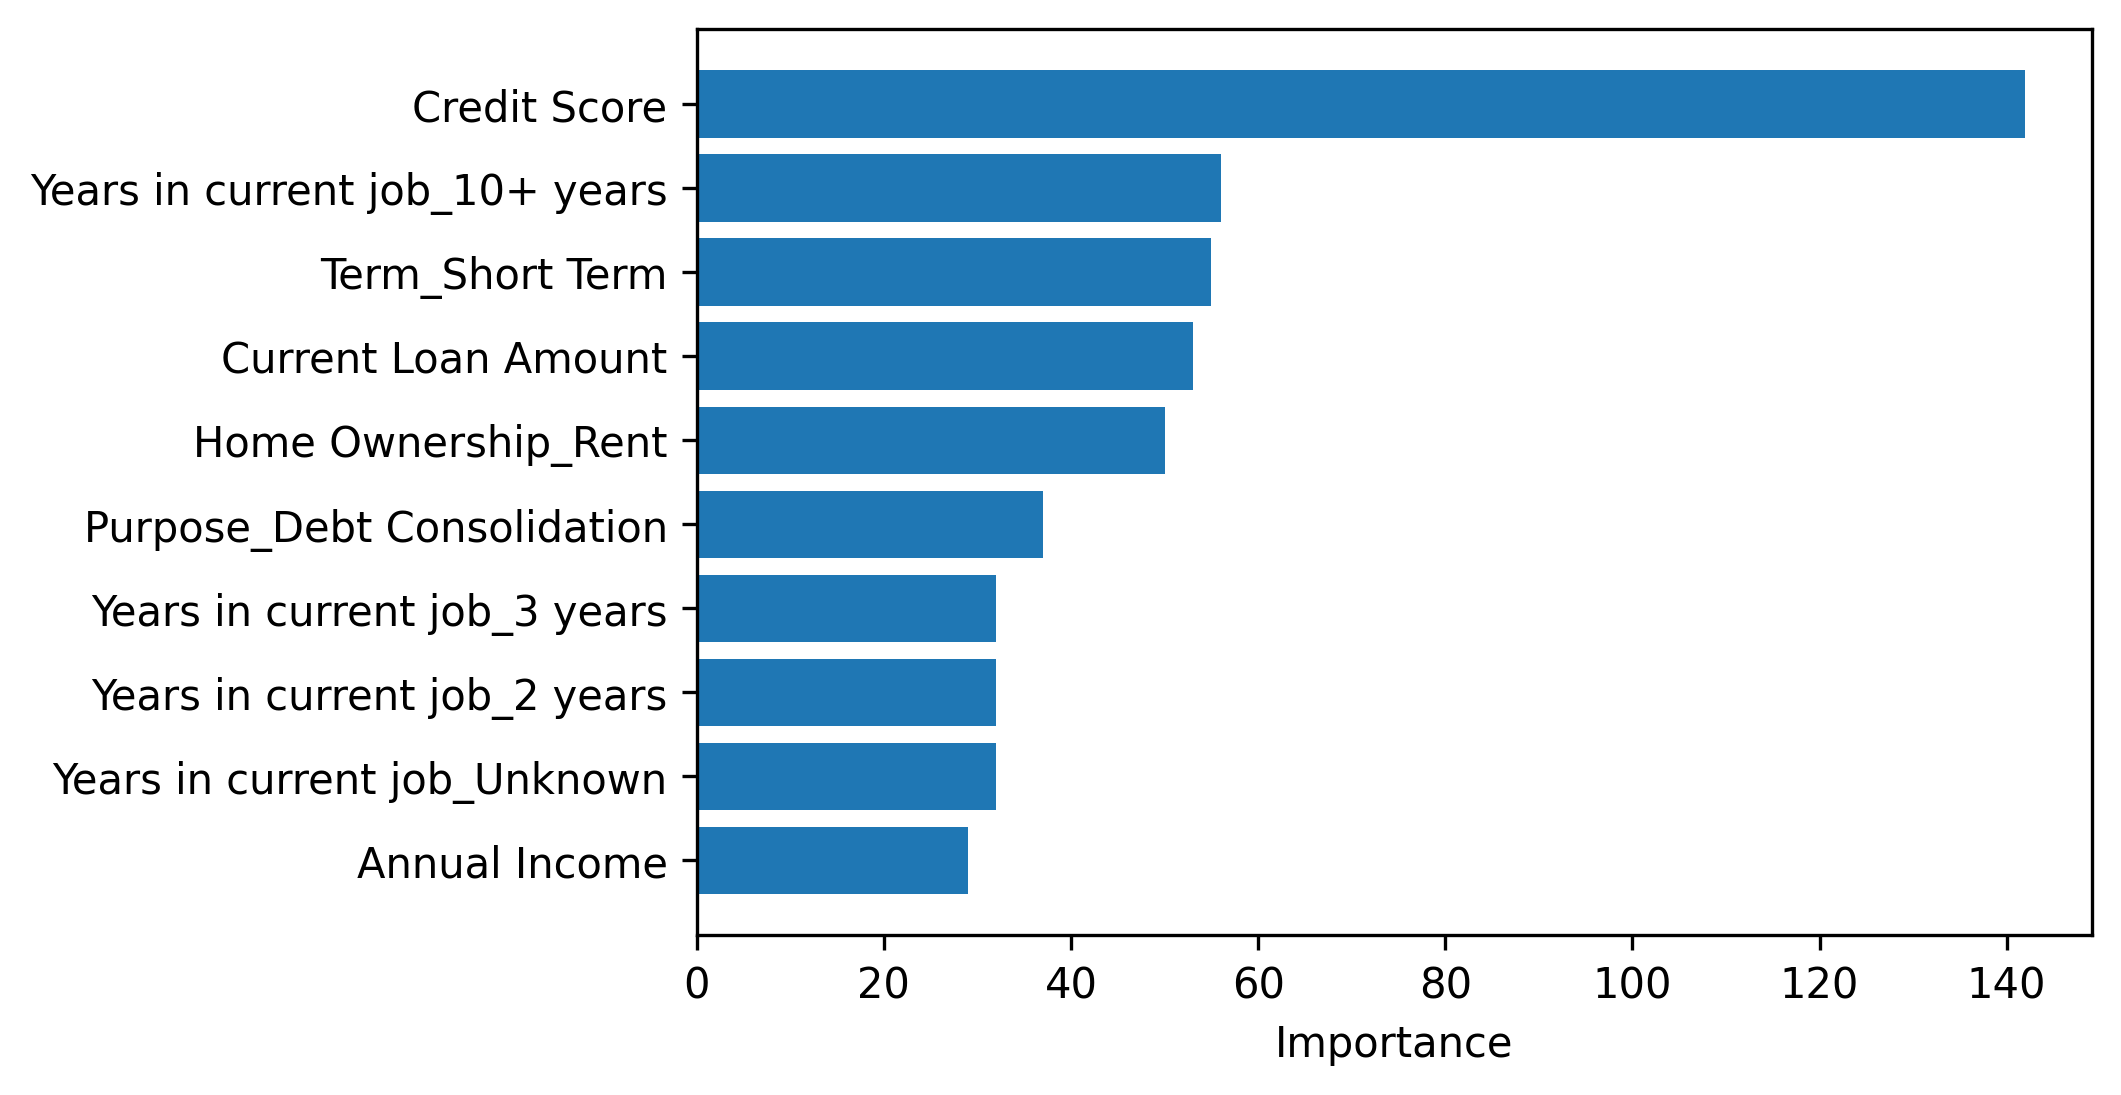

In [56]:


plt.rcParams['figure.dpi'] = 300
#mdl_pipe_impute.fit(X, y)
names = list(OneHot_module.transform(MeanImp_module.fit_transform(X)).columns)
feature_importances = mdl_pipe_impute.named_steps['model'].feature_importances_
imp = pd.DataFrame({'Features': names,
                        'Importances': feature_importances})
imp.sort_values(by='Importances', inplace=True)
imp = imp.tail(10)
plt.barh(imp['Features'], imp['Importances'])
plt.xlabel('Importance')
plt.show()

In [42]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

In [41]:
sum(y)

22639

In [96]:
y1 = y.head(10000)
X1 = X.head(10000)

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.3, random_state=1)

mdl_pipe_impute = imbPipeline(
    [
     ('mis', MeanImp_module),
    ('encode', OneHot_module),
     ('Scaling', RobScal_mdl),
      ('Trans', YeoJTrans_module), 
        #('imb', ADASYN_module),
        ('model', lgbm_mdl)
    ]
)

mdl_pipe_impute.fit(X_train, y_train)
Gini(y_test, mdl_pipe_impute.predict_proba(X_test)[:, 1])

0.49893569604137467

In [132]:
X2

,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
87312,449196.0,Long Term,719.0,911658.0,4 years,Home Mortgage,Debt Consolidation,22031.83,17.1,32.0,17.0,0.0,297274.0,969628.0,0.0,0.0
463,130746.0,Short Term,734.0,1018590.0,10+ years,Rent,Debt Consolidation,16891.57,22.8,29.0,7.0,1.0,41230.0,191686.0,1.0,0.0
9979,213752.0,Short Term,730.0,1365321.0,2 years,Home Mortgage,Debt Consolidation,11832.82,15.6,14.0,12.0,0.0,479066.0,1006742.0,0.0,0.0
6564,370744.0,Short Term,711.0,726180.0,10+ years,Rent,Debt Consolidation,10832.09,21.7,30.0,11.0,0.0,280060.0,472714.0,0.0,0.0
59199,103070.0,Short Term,689.0,1112640.0,1 year,Rent,Debt Consolidation,13908.00,18.0,57.0,7.0,1.0,80199.0,197582.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85570,122562.0,Short Term,718.0,1118948.0,10+ years,Rent,Debt Consolidation,11749.03,25.9,39.0,18.0,1.0,70737.0,309056.0,1.0,0.0
77675,286924.0,Short Term,699.0,1126320.0,10+ years,Rent,Debt Consolidation,9292.14,14.3,20.0,8.0,1.0,77577.0,176154.0,1.0,0.0
36441,314842.0,Long Term,726.0,849699.0,10+ years,Home Mortgage,Debt Consolidation,8638.54,15.9,25.0,8.0,0.0,203414.0,367466.0,0.0,0.0
77606,111254.0,Short Term,718.0,807101.0,4 years,Own Home,Debt Consolidation,3342.67,19.8,30.0,4.0,0.0,110352.0,256080.0,0.0,0.0


In [184]:
y2.reset_index(inplace=True, drop=True)
X2.reset_index(inplace=True, drop=True)

In [161]:
sum(y2.isna())

0

In [173]:
X2

,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
6448,99999999.0,Short Term,743.0,773148.0,< 1 year,Rent,Debt Consolidation,16365.08,15.5,46.0,21.0,0.0,150062.0,310838.0,0.0,0.0
50680,65472.0,Short Term,7410.0,942400.0,4 years,Rent,Business Loan,15643.84,10.9,18.0,7.0,0.0,27645.0,133408.0,0.0,0.0
814,262988.0,Short Term,7210.0,794960.0,3 years,Rent,Debt Consolidation,18880.49,15.4,81.0,6.0,0.0,30267.0,87626.0,0.0,0.0
20354,132704.0,Short Term,713.0,513475.0,< 1 year,Rent,Other,2195.07,17.7,56.0,6.0,0.0,75107.0,123882.0,0.0,0.0
49224,529364.0,Short Term,748.0,2000187.0,10+ years,Home Mortgage,Debt Consolidation,58338.74,22.0,14.0,8.0,0.0,423092.0,1010086.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81967,458128.0,Long Term,719.0,900049.0,5 years,Home Mortgage,Debt Consolidation,26776.51,14.3,27.0,9.0,0.0,25441.0,230186.0,0.0,0.0
24977,110462.0,Short Term,744.0,1106636.0,< 1 year,Own Home,Debt Consolidation,9166.55,11.3,NaN,6.0,0.0,120137.0,167816.0,0.0,0.0
29299,661188.0,Long Term,7230.0,1379989.0,5 years,Home Mortgage,Debt Consolidation,35419.42,31.0,13.0,10.0,0.0,440097.0,753830.0,0.0,0.0
80705,99999999.0,Short Term,737.0,733761.0,7 years,Home Mortgage,Debt Consolidation,14430.50,20.2,NaN,6.0,1.0,277172.0,517638.0,1.0,0.0


In [174]:
for col in X.columns:
    print(f'Количество пропусков по фактору {col}:\n\t{X2[col].isna().sum()} или {X2[col].isna().sum() / df.shape[1] * 100}%')

Количество пропусков по фактору Current Loan Amount:
	0 или 0.0%
Количество пропусков по фактору Term:
	0 или 0.0%
Количество пропусков по фактору Credit Score:
	187 или 1100.0%
Количество пропусков по фактору Annual Income:
	187 или 1100.0%
Количество пропусков по фактору Years in current job:
	0 или 0.0%
Количество пропусков по фактору Home Ownership:
	0 или 0.0%
Количество пропусков по фактору Purpose:
	0 или 0.0%
Количество пропусков по фактору Monthly Debt:
	0 или 0.0%
Количество пропусков по фактору Years of Credit History:
	0 или 0.0%
Количество пропусков по фактору Months since last delinquent:
	531 или 3123.529411764706%
Количество пропусков по фактору Number of Open Accounts:
	0 или 0.0%
Количество пропусков по фактору Number of Credit Problems:
	0 или 0.0%
Количество пропусков по фактору Current Credit Balance:
	0 или 0.0%
Количество пропусков по фактору Maximum Open Credit:
	0 или 0.0%
Количество пропусков по фактору Bankruptcies:
	0 или 0.0%
Количество пропусков по фактору

In [186]:
from imblearn.pipeline import Pipeline as imbPipeline
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from functools import partial
from sklearn.model_selection import cross_val_score, StratifiedKFold
seed = 42
lgbm_mdl = LGBMClassifier(
    num_leaves = 12,
    learning_rate = .1,
    reg_alpha = 0,
    reg_lambda = 9,
    n_estimators= 100,
    random_state = seed
)

mdl_pipe_impute = imbPipeline(
    [
     ('mis', MeanImp_module),
    ('encode', WoE_module),
     ('Scaling', RobScal_mdl),
      ('Trans', YeoJTrans_module), 
        #('imb', ADASYN_module),
        ('model', lgbm_mdl)
    ]
)

search_space = {
    #'Select__n_components':    hp.choice('Select__n_componentse',    np.arange(10, 21, 1, dtype=int)),
    #'Select__n_neighbors':    hp.choice('Select__n_neighbors',    np.arange(3, 8, 1, dtype=int)),
    'model__learning_rate':    hp.choice('model__learning_rate',    np.arange(0.01, 0.1, 0.01)),
    'model__num_leaves':       hp.choice('model__num_leaves',       np.arange(5, 17, 1, dtype=int)),
    'model__reg_alpha':        hp.choice('model__reg_alpha',        np.arange(0, 16, 1, dtype=int)),
    'model__reg_lambda':       hp.choice('model__reg_lambda',       np.arange(0, 16, 1, dtype=int)),
    'model__n_estimators':     hp.choice('model__n_estimators',       np.arange(50, 160, 10, dtype=int)),
                }



def objective(params, pipeline,  X_train, y_train):
    """
    Кросс-валидация с текущими гиперпараметрами

    :params: гиперпараметры
    :pipeline: модель
    :X_train: матрица признаков
    :y_train: вектор меток объектов
    :return: средняя точность на кросс-валидации
    """ 

    # задаём модели требуемые параметры    
    pipeline.set_params(**params)

    # задаём параметры кросс-валидации (стратифицированная 4-фолдовая с перемешиванием)
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

    # проводим кросс-валидацию  
    score = cross_val_score(estimator=pipeline, X=X_train, y=y_train, 
                            cv=skf, n_jobs=-1)

    # возвращаем результаты, которые записываются в Trials()
    return   {'loss': -score.mean(), 'params': params, 'status': STATUS_OK}


trials = Trials()
best = fmin( 
          # функция для оптимизации  
            fn=partial(objective, pipeline=mdl_pipe_impute, X_train=X2, y_train=y2),
          # пространство поиска гиперпараметров  
            space=search_space,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
          # (можно ещё указать и время поиска) 
            max_evals=40,
          # куда сохранять историю поиска
            trials=trials,
          # random state
            rstate=np.random.RandomState(1),
          # progressbar
            show_progressbar=True
        )
from hyperopt import space_eval
best_params = space_eval(search_space, best)
mdl_pipe_impute.set_params(**best_params)

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")
mdl_pipe_impute.fit(X2, y2)
c = Gini(y2, mdl_pipe_impute.predict_proba(X2)[:, 1])
c1 = balanced_accuracy_score(y2, mdl_pipe_impute.predict(X2))
c2 = f1_score(y2, mdl_pipe_impute.predict(X2))
gini = []
b_acc = []
f1 = []
for i in range(100):

    mdl_pipe_impute.fit(X_train_b[i], y_train_b[i])

    gini.append(0.632*Gini(y_bag[i], mdl_pipe_impute.predict_proba(X_bag[i])[:, 1]) + c*0.368)
    b_acc.append(0.632*balanced_accuracy_score(y_bag[i], mdl_pipe_impute.predict(X_bag[i])) + c1*0.368)
    f1.append(0.632*f1_score(y_bag[i], mdl_pipe_impute.predict(X_bag[i])) + c2*0.368)

 25%|████████████████▌                                                 | 10/40 [00:08<00:24,  1.25trial/s, best loss=?]


KeyboardInterrupt: 

In [185]:
X2 = ZeroImp_module.fit_transform(X2)

In [135]:
np.mean(gini)

0.6045959447569174

In [16]:
results_lgbm = pd.DataFrame({"full" : gini})
results1_lgbm = pd.DataFrame({"full" : b_acc})
results2_lgbm = pd.DataFrame({"full" : f1})

In [ ]:
np.mean(b_acc)

In [17]:
from imblearn.pipeline import Pipeline as imbPipeline
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from functools import partial
from sklearn.model_selection import cross_val_score, StratifiedKFold
seed = 42
lgbm_mdl = LGBMClassifier(
    num_leaves = 12,
    learning_rate = .1,
    reg_alpha = 0,
    reg_lambda = 9,
    n_estimators= 100,
    random_state = seed
)

mdl_pipe_impute = imbPipeline(
    [
        ('mis', MedImp_module),
    ('encode', OneHot_module),
     ('Scaling', RobScal_mdl),
      #('Trans', YeoJTrans_module),  
        ('model', lgbm_mdl)
    ]
)

search_space = {
    #'Select__n_components':    hp.choice('Select__n_componentse',    np.arange(10, 21, 1, dtype=int)),
    #'Select__n_neighbors':    hp.choice('Select__n_neighbors',    np.arange(3, 8, 1, dtype=int)),
    'model__learning_rate':    hp.choice('model__learning_rate',    np.arange(0.01, 0.1, 0.01)),
    'model__num_leaves':       hp.choice('model__num_leaves',       np.arange(5, 17, 1, dtype=int)),
    'model__reg_alpha':        hp.choice('model__reg_alpha',        np.arange(0, 16, 1, dtype=int)),
    'model__reg_lambda':       hp.choice('model__reg_lambda',       np.arange(0, 16, 1, dtype=int)),
    'model__n_estimators':     hp.choice('model__n_estimators',       np.arange(50, 160, 10, dtype=int)),
                }



def objective(params, pipeline,  X_train, y_train):
    """
    Кросс-валидация с текущими гиперпараметрами

    :params: гиперпараметры
    :pipeline: модель
    :X_train: матрица признаков
    :y_train: вектор меток объектов
    :return: средняя точность на кросс-валидации
    """ 

    # задаём модели требуемые параметры    
    pipeline.set_params(**params)

    # задаём параметры кросс-валидации (стратифицированная 4-фолдовая с перемешиванием)
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

    # проводим кросс-валидацию  
    score = cross_val_score(estimator=pipeline, X=X_train, y=y_train, 
                            cv=skf, n_jobs=-1)

    # возвращаем результаты, которые записываются в Trials()
    return   {'loss': -score.mean(), 'params': params, 'status': STATUS_OK}


trials = Trials()
best = fmin( 
          # функция для оптимизации  
            fn=partial(objective, pipeline=mdl_pipe_impute, X_train=X, y_train=y),
          # пространство поиска гиперпараметров  
            space=search_space,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
          # (можно ещё указать и время поиска) 
            max_evals=40,
          # куда сохранять историю поиска
            trials=trials,
          # random state
            rstate=np.random.RandomState(1),
          # progressbar
            show_progressbar=True
        )
from hyperopt import space_eval
best_params = space_eval(search_space, best)
mdl_pipe_impute.set_params(**best_params)

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")
mdl_pipe_impute.fit(X, y)
c = Gini(y, mdl_pipe_impute.predict_proba(X)[:, 1])
c1 = balanced_accuracy_score(y, mdl_pipe_impute.predict(X))
c2 = f1_score(y, mdl_pipe_impute.predict(X))
gini = []
b_acc = []
f1 = []
for i in range(100):

    mdl_pipe_impute.fit(X_train_b[i], y_train_b[i])

    gini.append(0.632*Gini(y_bag[i], mdl_pipe_impute.predict_proba(X_bag[i])[:, 1]) + c*0.368)
    b_acc.append(0.632*balanced_accuracy_score(y_bag[i], mdl_pipe_impute.predict(X_bag[i])) + c1*0.368)
    f1.append(0.632*f1_score(y_bag[i], mdl_pipe_impute.predict(X_bag[i])) + c2*0.368)

100%|████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.39trial/s, best loss: -0.758]


In [18]:
results_lgbm['No transformation'] = gini
results1_lgbm['No transformation'] = b_acc
results2_lgbm['No transformation'] = f1

In [19]:
from imblearn.pipeline import Pipeline as imbPipeline
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from functools import partial
from sklearn.model_selection import cross_val_score, StratifiedKFold
seed = 42
lgbm_mdl = LGBMClassifier(
    num_leaves = 12,
    learning_rate = .1,
    reg_alpha = 0,
    reg_lambda = 9,
    n_estimators= 100,
    random_state = seed
)

mdl_pipe_impute = imbPipeline(
    [
        ('mis', MedImp_module),
    ('encode', OneHot_module),
     #('Scaling', RobScal_mdl),
      ('Trans', YeoJTrans_module),  
        ('model', lgbm_mdl)
    ]
)

search_space = {
    #'Select__n_components':    hp.choice('Select__n_componentse',    np.arange(10, 21, 1, dtype=int)),
    #'Select__n_neighbors':    hp.choice('Select__n_neighbors',    np.arange(3, 8, 1, dtype=int)),
    'model__learning_rate':    hp.choice('model__learning_rate',    np.arange(0.01, 0.1, 0.01)),
    'model__num_leaves':       hp.choice('model__num_leaves',       np.arange(5, 17, 1, dtype=int)),
    'model__reg_alpha':        hp.choice('model__reg_alpha',        np.arange(0, 16, 1, dtype=int)),
    'model__reg_lambda':       hp.choice('model__reg_lambda',       np.arange(0, 16, 1, dtype=int)),
    'model__n_estimators':     hp.choice('model__n_estimators',       np.arange(50, 160, 10, dtype=int)),
                }



def objective(params, pipeline,  X_train, y_train):
    """
    Кросс-валидация с текущими гиперпараметрами

    :params: гиперпараметры
    :pipeline: модель
    :X_train: матрица признаков
    :y_train: вектор меток объектов
    :return: средняя точность на кросс-валидации
    """ 

    # задаём модели требуемые параметры    
    pipeline.set_params(**params)

    # задаём параметры кросс-валидации (стратифицированная 4-фолдовая с перемешиванием)
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

    # проводим кросс-валидацию  
    score = cross_val_score(estimator=pipeline, X=X_train, y=y_train, 
                            cv=skf, n_jobs=-1)

    # возвращаем результаты, которые записываются в Trials()
    return   {'loss': -score.mean(), 'params': params, 'status': STATUS_OK}


trials = Trials()
best = fmin( 
          # функция для оптимизации  
            fn=partial(objective, pipeline=mdl_pipe_impute, X_train=X, y_train=y),
          # пространство поиска гиперпараметров  
            space=search_space,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
          # (можно ещё указать и время поиска) 
            max_evals=40,
          # куда сохранять историю поиска
            trials=trials,
          # random state
            rstate=np.random.RandomState(1),
          # progressbar
            show_progressbar=True
        )
from hyperopt import space_eval
best_params = space_eval(search_space, best)
mdl_pipe_impute.set_params(**best_params)

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")
mdl_pipe_impute.fit(X, y)
c = Gini(y, mdl_pipe_impute.predict_proba(X)[:, 1])
c1 = balanced_accuracy_score(y, mdl_pipe_impute.predict(X))
c2 = f1_score(y, mdl_pipe_impute.predict(X))
gini = []
b_acc = []
f1 = []
for i in range(100):

    mdl_pipe_impute.fit(X_train_b[i], y_train_b[i])

    gini.append(0.632*Gini(y_bag[i], mdl_pipe_impute.predict_proba(X_bag[i])[:, 1]) + c*0.368)
    b_acc.append(0.632*balanced_accuracy_score(y_bag[i], mdl_pipe_impute.predict(X_bag[i])) + c1*0.368)
    f1.append(0.632*f1_score(y_bag[i], mdl_pipe_impute.predict(X_bag[i])) + c2*0.368)

100%|███████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77trial/s, best loss: -0.7589999999999999]


In [20]:
results_lgbm['No Scaling'] = gini
results1_lgbm['No Scaling'] = b_acc
results2_lgbm['No Scaling'] = f1

In [21]:
from imblearn.pipeline import Pipeline as imbPipeline
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from functools import partial
from sklearn.model_selection import cross_val_score, StratifiedKFold
seed = 42
lgbm_mdl = LGBMClassifier(
    num_leaves = 12,
    learning_rate = .1,
    reg_alpha = 0,
    reg_lambda = 9,
    n_estimators= 100,
    random_state = seed
)

mdl_pipe_impute = imbPipeline(
    [
        ('mis', MedImp_module),
    ('encode', WoE_module),
     ('Scaling', RobScal_mdl),
      ('Trans', YeoJTrans_module),  
        ('model', lgbm_mdl)
    ]
)

search_space = {
    #'Select__n_components':    hp.choice('Select__n_componentse',    np.arange(10, 21, 1, dtype=int)),
    #'Select__n_neighbors':    hp.choice('Select__n_neighbors',    np.arange(3, 8, 1, dtype=int)),
    'model__learning_rate':    hp.choice('model__learning_rate',    np.arange(0.01, 0.1, 0.01)),
    'model__num_leaves':       hp.choice('model__num_leaves',       np.arange(5, 17, 1, dtype=int)),
    'model__reg_alpha':        hp.choice('model__reg_alpha',        np.arange(0, 16, 1, dtype=int)),
    'model__reg_lambda':       hp.choice('model__reg_lambda',       np.arange(0, 16, 1, dtype=int)),
    'model__n_estimators':     hp.choice('model__n_estimators',       np.arange(50, 160, 10, dtype=int)),
                }



def objective(params, pipeline,  X_train, y_train):
    """
    Кросс-валидация с текущими гиперпараметрами

    :params: гиперпараметры
    :pipeline: модель
    :X_train: матрица признаков
    :y_train: вектор меток объектов
    :return: средняя точность на кросс-валидации
    """ 

    # задаём модели требуемые параметры    
    pipeline.set_params(**params)

    # задаём параметры кросс-валидации (стратифицированная 4-фолдовая с перемешиванием)
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

    # проводим кросс-валидацию  
    score = cross_val_score(estimator=pipeline, X=X_train, y=y_train, 
                            cv=skf, n_jobs=-1)

    # возвращаем результаты, которые записываются в Trials()
    return   {'loss': -score.mean(), 'params': params, 'status': STATUS_OK}


trials = Trials()
best = fmin( 
          # функция для оптимизации  
            fn=partial(objective, pipeline=mdl_pipe_impute, X_train=X, y_train=y),
          # пространство поиска гиперпараметров  
            space=search_space,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
          # (можно ещё указать и время поиска) 
            max_evals=40,
          # куда сохранять историю поиска
            trials=trials,
          # random state
            rstate=np.random.RandomState(1),
          # progressbar
            show_progressbar=True
        )
from hyperopt import space_eval
best_params = space_eval(search_space, best)
mdl_pipe_impute.set_params(**best_params)

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")
mdl_pipe_impute.fit(X, y)
c = Gini(y, mdl_pipe_impute.predict_proba(X)[:, 1])
c1 = balanced_accuracy_score(y, mdl_pipe_impute.predict(X))
c2 = f1_score(y, mdl_pipe_impute.predict(X))
gini = []
b_acc = []
f1 = []
for i in range(100):

    mdl_pipe_impute.fit(X_train_b[i], y_train_b[i])

    gini.append(0.632*Gini(y_bag[i], mdl_pipe_impute.predict_proba(X_bag[i])[:, 1]) + c*0.368)
    b_acc.append(0.632*balanced_accuracy_score(y_bag[i], mdl_pipe_impute.predict(X_bag[i])) + c1*0.368)
    f1.append(0.632*f1_score(y_bag[i], mdl_pipe_impute.predict(X_bag[i])) + c2*0.368)

100%|████████████████████████████████████████████████████████████| 40/40 [00:12<00:00,  3.22trial/s, best loss: -0.764]


In [22]:
results_lgbm['No OneHot encoding'] = gini
results1_lgbm['No OneHot encoding'] = b_acc
results2_lgbm['No OneHot encoding'] = f1

In [23]:
results_lgbm.mean()

full                  0.695323
No transformation     0.695218
No Scaling            0.672486
No OneHot encoding    0.656694
dtype: float64

In [24]:
results1_lgbm.mean()

full                  0.754510
No transformation     0.754419
No Scaling            0.726727
No OneHot encoding    0.712943
dtype: float64

In [25]:
results2_lgbm.mean()

full                  0.655201
No transformation     0.655041
No Scaling            0.615928
No OneHot encoding    0.595024
dtype: float64

In [26]:
results_lgbm.std()

full                  0.023742
No transformation     0.023668
No Scaling            0.023807
No OneHot encoding    0.023870
dtype: float64

In [27]:
results1_lgbm.std()

full                  0.015399
No transformation     0.015402
No Scaling            0.014217
No OneHot encoding    0.014318
dtype: float64

In [28]:
results2_lgbm.std()

full                  0.025609
No transformation     0.025615
No Scaling            0.023755
No OneHot encoding    0.023989
dtype: float64

In [29]:
from scipy import stats
stats.ttest_ind(results_lgbm['full'], results_lgbm['No transformation'], equal_var = False)

Ttest_indResult(statistic=0.031218135194389793, pvalue=0.9751270228754978)

In [30]:
stats.ttest_ind(results1_lgbm['full'], results1_lgbm['No transformation'], equal_var = False)

Ttest_indResult(statistic=0.04180049164886303, pvalue=0.9666998640835496)

In [31]:
stats.ttest_ind(results2_lgbm['full'], results2_lgbm['No transformation'], equal_var = False)

Ttest_indResult(statistic=0.04408030060349551, pvalue=0.9648848179859284)

In [32]:
stats.ttest_ind(results_lgbm['full'], results_lgbm['No Scaling'], equal_var = False)

Ttest_indResult(statistic=6.792075617025046, pvalue=1.2617164742618014e-10)

In [33]:
stats.ttest_ind(results1_lgbm['full'], results1_lgbm['No Scaling'], equal_var = False)

Ttest_indResult(statistic=13.25627777906048, pvalue=4.4347635527730056e-29)

In [34]:
stats.ttest_ind(results2_lgbm['full'], results2_lgbm['No Scaling'], equal_var = False)

Ttest_indResult(statistic=11.243254160848258, pvalue=5.641653174539998e-23)

In [35]:
stats.ttest_ind(results_lgbm['full'], results_lgbm['No OneHot encoding'], equal_var = False)

Ttest_indResult(statistic=11.473771984897075, pvalue=1.0770633096839913e-23)

In [36]:
stats.ttest_ind(results1_lgbm['full'], results1_lgbm['No OneHot encoding'], equal_var = False)

Ttest_indResult(statistic=19.76857791017308, pvalue=1.2065235363751412e-48)

In [37]:
stats.ttest_ind(results2_lgbm['full'], results2_lgbm['No OneHot encoding'], equal_var = False)

Ttest_indResult(statistic=17.149582871442163, pvalue=5.983778737908159e-41)

[Text(0.5, 1.0, 'LGBM and preprocessing')]

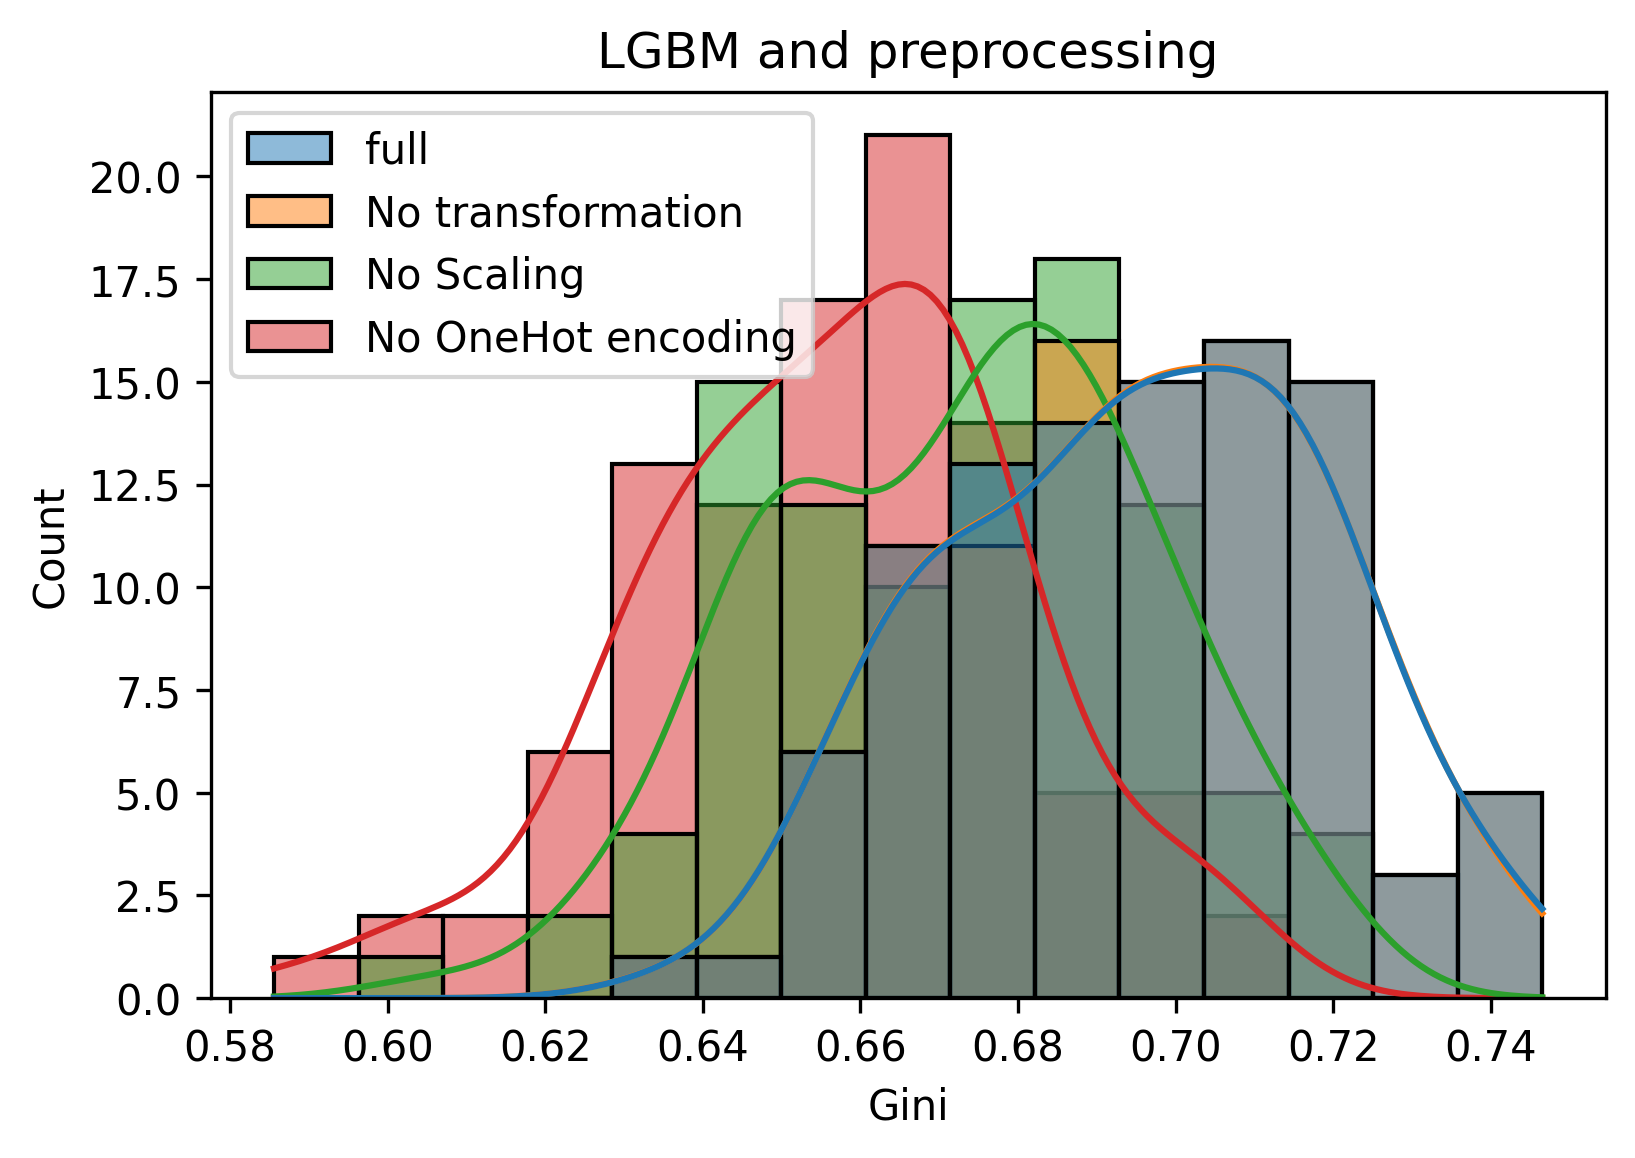

In [38]:
plt.rcParams['figure.dpi'] = 300
ax = sns.histplot(results_lgbm, kde=True, element = 'bars')
ax.set_xlabel("Gini", fontsize = 10)
ax.set(title='LGBM and preprocessing')

[Text(0.5, 1.0, 'LGBM and preprocessing')]

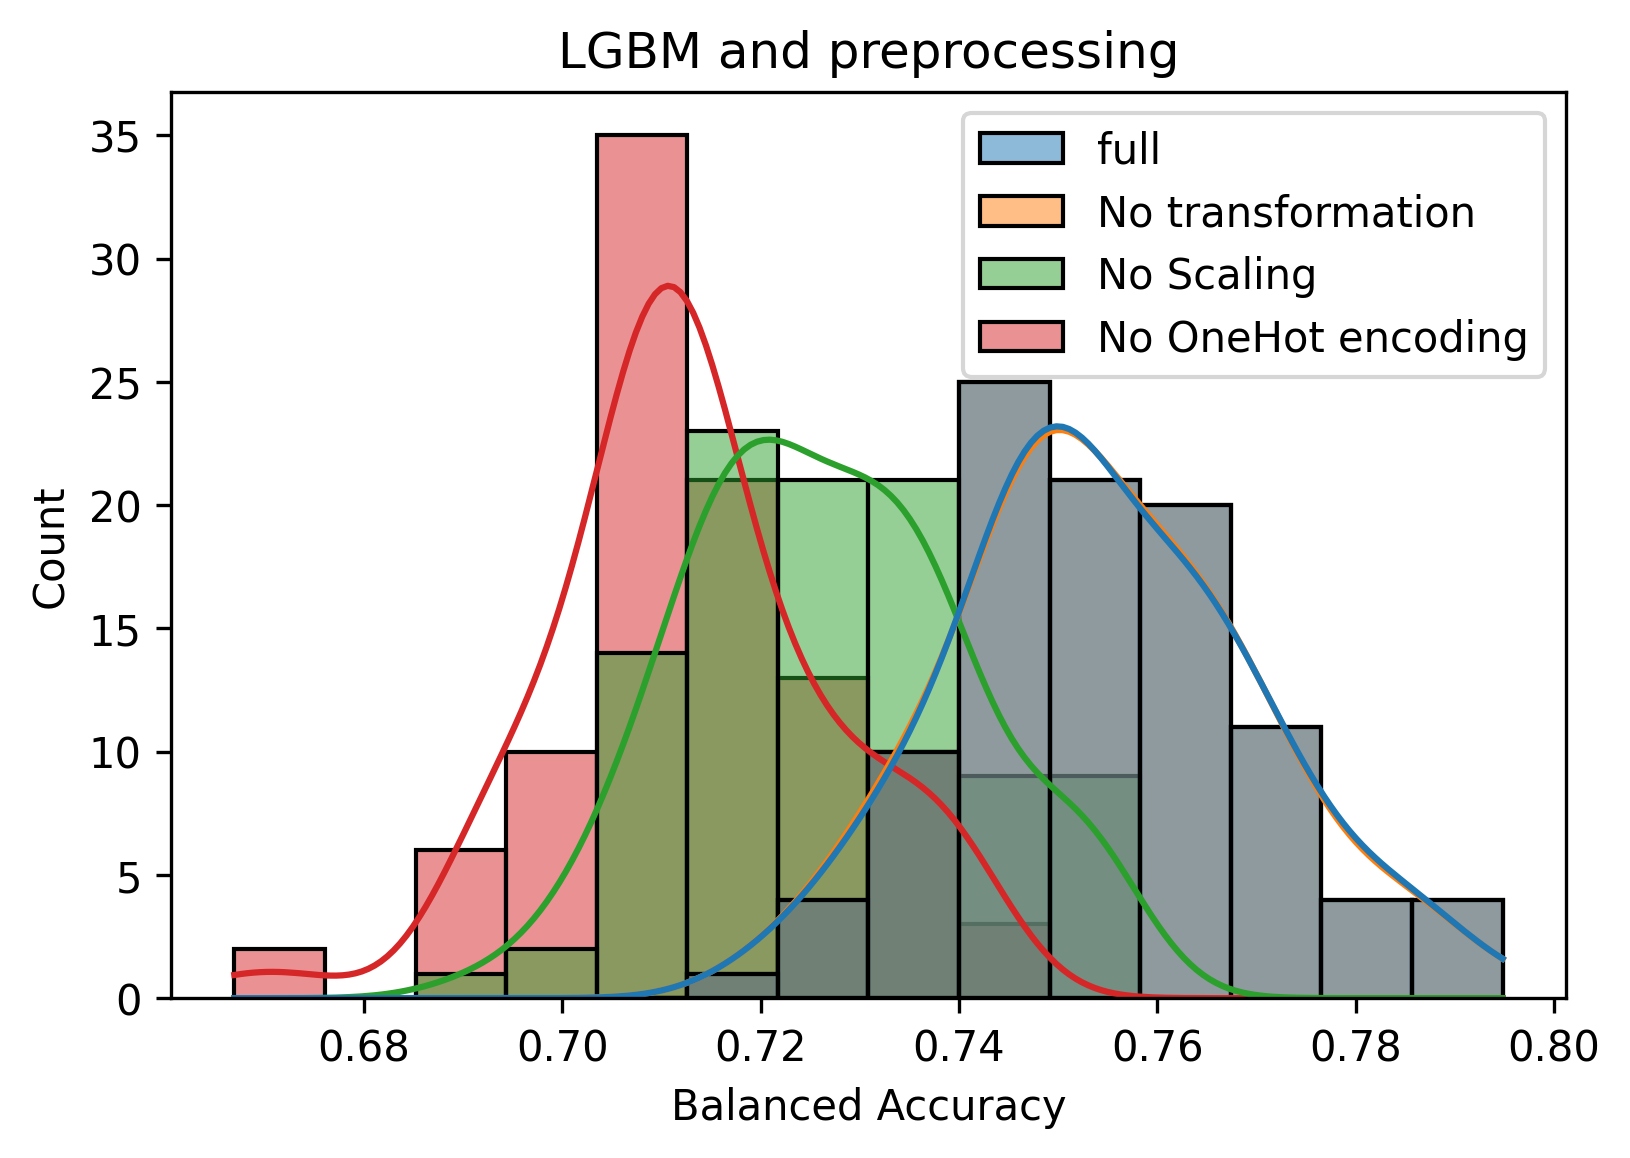

In [39]:
ax = sns.histplot(results1_lgbm, kde=True, element = 'bars')
ax.set_xlabel("Balanced Accuracy", fontsize = 10)
ax.set(title='LGBM and preprocessing')

[Text(0.5, 1.0, 'LGBM and preprocessing')]

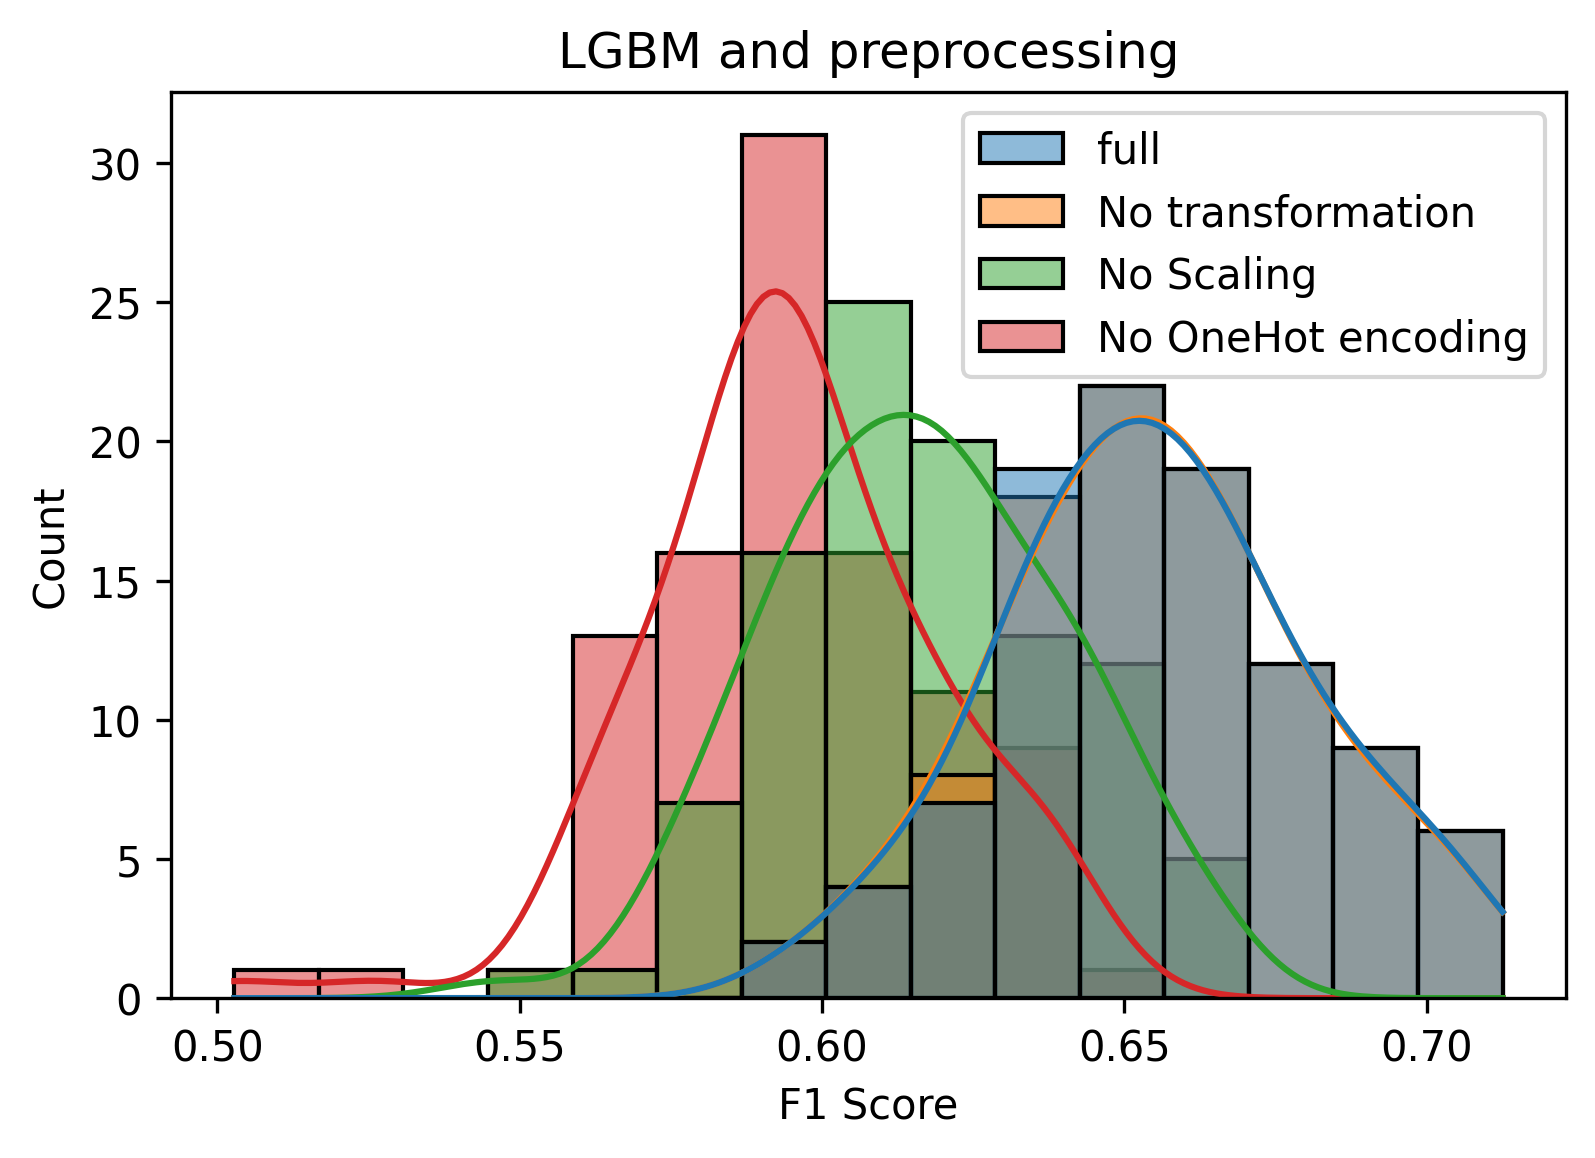

In [40]:
ax = sns.histplot(results2_lgbm, kde=True, element = 'bars')
ax.set_xlabel("F1 Score", fontsize = 10)
ax.set(title='LGBM and preprocessing')